In [1]:
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

2023-09-05 21:27:12.997107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 21:27:14.349232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
aapl = yf.download('aapl',start = '2000-01-01',end = '2023-08-25')
vix = yf.download('^VIX',start = '2000-01-01',end = '2023-08-25')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


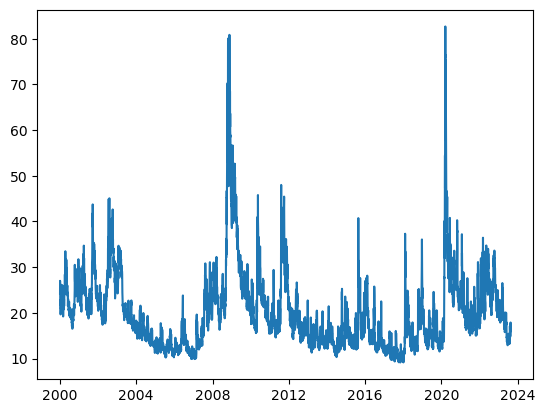

In [3]:
plt.plot(vix['Close'])

In [4]:
aapl['VIX'] = vix['High']

In [5]:
print(aapl.head())

                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2000-01-03  0.936384  1.004464  0.907924  0.999442   0.848323  535796800   
2000-01-04  0.966518  0.987723  0.903460  0.915179   0.776801  512377600   
2000-01-05  0.926339  0.987165  0.919643  0.928571   0.788168  778321600   
2000-01-06  0.947545  0.955357  0.848214  0.848214   0.719961  767972800   
2000-01-07  0.861607  0.901786  0.852679  0.888393   0.754065  460734400   

                  VIX  
Date                   
2000-01-03  26.150000  
2000-01-04  27.180000  
2000-01-05  29.000000  
2000-01-06  26.709999  
2000-01-07  25.170000  


In [6]:
def train_test_split(dataset, tstart, tend, feature_list):
    train = dataset.loc[f"{tstart}":f"{tend}", feature_list].values
    test = dataset.loc[f"{tend+1}":, feature_list].values
    
    return train, test

In [7]:
tstart = 2000 
tend = 2021
feature_list = ['High','Volume','VIX']
training_set, test_set = train_test_split(aapl,tstart, tend, feature_list)
test_set

array([[1.82880005e+02, 1.04487900e+08, 1.85400009e+01],
       [1.82940002e+02, 9.93104000e+07, 1.78099995e+01],
       [1.80169998e+02, 9.45376000e+07, 2.01700001e+01],
       ...,
       [1.77679993e+02, 4.20842000e+07, 1.75799999e+01],
       [1.81550003e+02, 5.27228000e+07, 1.71000004e+01],
       [1.81100006e+02, 5.49458000e+07, 1.73199997e+01]])

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))

In [10]:
# training_set = training_set.reshape(-1,1)
training_set_scaled = scaler.fit_transform(training_set)
training_set_scaled

array([[0.00422733, 0.0672496 , 0.20992271],
       [0.00413529, 0.06407726, 0.22276241],
       [0.00413223, 0.1001018 , 0.24545001],
       ...,
       [0.99175346, 0.00311677, 0.1083271 ],
       [0.99142361, 0.00276784, 0.10570931],
       [0.98405664, 0.00334886, 0.11169285]])

In [11]:
def split_sequence(sequence, n_steps):
    X, y = [], [] 
    for i in range(len(sequence)):
        end_idx = i + n_steps
        if end_idx > len(sequence) - 1: 
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx][0:1]
        X.append(seq_x)
        y.append(seq_y) 
    return np.array(X), np.array(y)

In [12]:
n_steps = 6 
features = 3

X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [13]:
X_train.shape

(5530, 6, 3)

In [14]:
# X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], features)

In [15]:
X_train.shape

(5530, 6, 3)

In [16]:
model_lstm = Sequential()
model_lstm.add(LSTM(units = 125, activation='tanh', input_shape=(None,features),))
model_lstm.add(Dense(units = 1))
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               64500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 64,626
Trainable params: 64,626
Non-trainable params: 0
_________________________________________________________________


2023-09-05 21:27:22.519505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-05 21:27:22.546235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-05 21:27:22.546372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
model_lstm.fit(X_train,y_train,batch_size=32, epochs=50)

Epoch 1/50


2023-09-05 21:27:23.394906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-05 21:27:23.395880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-05 21:27:23.396614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

173/173 [==============================] - 2s 2ms/step - loss: 0.0020
Epoch 2/50
173/173 [==============================] - 0s 2ms/step - loss: 1.6994e-04
Epoch 3/50
173/173 [==============================] - 0s 2ms/step - loss: 1.4984e-04
Epoch 4/50
173/173 [==============================] - 0s 2ms/step - loss: 1.3183e-04
Epoch 5/50
173/173 [==============================] - 0s 2ms/step - loss: 1.3185e-04
Epoch 6/50
173/173 [==============================] - 0s 2ms/step - loss: 1.2463e-04
Epoch 7/50
173/173 [==============================] - 0s 2ms/step - loss: 1.1311e-04
Epoch 8/50
173/173 [==============================] - 0s 2ms/step - loss: 1.0365e-04
Epoch 9/50
173/173 [==============================] - 0s 2ms/step - loss: 1.0061e-04
Epoch 10/50
173/173 [==============================] - 0s 2ms/step - loss: 9.1887e-05
Epoch 11/50
173/173 [==============================] - 0s 2ms/step - loss: 8.7121e-05
Epoch 12/50
173/173 [==============================] - 0s 2ms/step - loss: 9.2

In [103]:
dataset_total = aapl.loc[:,feature_list]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
# inputs = inputs.reshape(-1, 1)
#scaling
inputs = scaler.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)

padded_predictions = np.zeros((predicted_stock_price.shape[0], features))

padded_predictions[:, 0] = predicted_stock_price.squeeze() 
inverse_transformed_predictions = scaler.inverse_transform(padded_predictions)
final_predictions = inverse_transformed_predictions[:, 0]
inverse_transformed_predictions


13/13 [==============================] - 0s 6ms/step


2023-08-27 16:39:58.837435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-27 16:39:58.838499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-27 16:39:58.839153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

array([[1.81911825e+02, 3.93400000e+07, 9.31000042e+00],
       [1.83040409e+02, 3.93400000e+07, 9.31000042e+00],
       [1.83873186e+02, 3.93400000e+07, 9.31000042e+00],
       ...,
       [1.77460027e+02, 3.93400000e+07, 9.31000042e+00],
       [1.77902436e+02, 3.93400000e+07, 9.31000042e+00],
       [1.79762870e+02, 3.93400000e+07, 9.31000042e+00]])

In [104]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


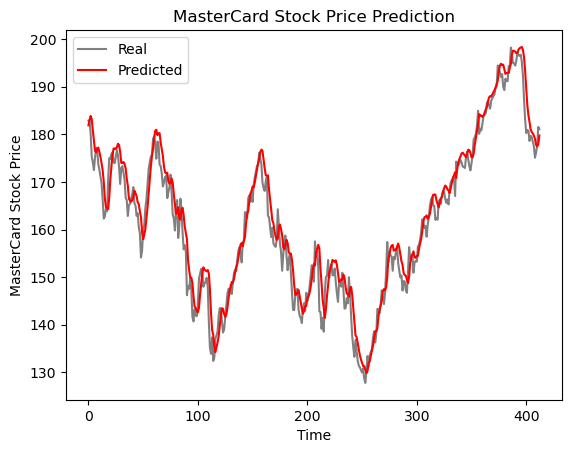

In [105]:
# test_set[:,0]
plot_predictions(test_set[:,0],final_predictions)